<a href="https://colab.research.google.com/github/Serbernari/NER-summarization/blob/main/bart_pretrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# VERY USEFULL https://github.com/jessevig/bertviz#encoder-decoder-models-bart-t5-etc

In [4]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 14.5 MB/s 
     |████████████████████████████████| 6.6 MB 62.7 MB/s 
     |████████████████████████████████| 596 kB 80.6 MB/s 
     |████████████████████████████████| 84 kB 4.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install jsonlines

In [1]:
import json
import jsonlines
import statistics
import copy
from tqdm import tqdm
import pandas as pd
import random
from datetime import datetime
import torch
from torch.optim import AdamW, lr_scheduler
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from linecache import getline
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import BartTokenizer, BartTokenizerFast, BartForConditionalGeneration, BartConfig
from transformers import pipeline

# Data preprocessing

creating target data for MLM

In [ ]:
with open("/content/drive/MyDrive/Diplom/Pretraining/target.txt", 'w+') as output: #"</s>"? won't it get cut? wont tokenizer add it?
  for filename in ["/content/arxiv-dataset/test.txt",
                  "/content/arxiv-dataset/train.txt",
                  "/content/arxiv-dataset/val.txt"]:
    with open(filename) as f:
        for i, line in enumerate(f):
          data = json.loads(line)              
          article_text = data['article_text']
          article_text = ' '.join(article_text)
          article_text+="</s>"
          article_text+="\n"
          output.write(article_text)


    

In [ ]:
def generate_input(example): #чтоб число токенов совпадало - сложносоставные слова это несколько масок.
#TODO: random masking of other words
  NER_mask_proba = 0.5
  tokenizer = AutoTokenizer.from_pretrained('roberta-base')
  model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/Diplom/NER/outputs/checkpoint-1372-epoch-7")
  nlp = pipeline("ner", model=model, tokenizer=tokenizer, device=0) 

  ner_results = nlp(example) #need to get rid of this list - unlist thing 
  output = []
    
  for i in range(len(ner_results)): # HERE LAYS RANDOM
    ents = set(x['word'].replace("Ġ", '') for x in ner_results[i] if x['entity'] != 'LABEL_0' and len(x["word"]) > 3 and random.random() >= NER_mask_proba) #select all words that are entities and not in cathegory "OTHER"
    words = ["<mask>" if x in ents else x for x in example[i].split()]
    output.append(" ".join(words))

  return output



In [ ]:
#generate_input(["this is experiment example", "with multiple strings attached method"])

In [ ]:
batch = []
batch_size = 100000

with open("/content/drive/MyDrive/Diplom/Pretraining/masked.txt", 'w+') as output:
  for filename in ["/content/arxiv-dataset/test.txt",
                   "/content/arxiv-dataset/train.txt",
                   "/content/arxiv-dataset/val.txt"]:
    file_len = sum(1 for line in open(filename))
    print(f"Working on {filename}. Lines in file: {file_len}")
    with open(filename) as f:
        for i, line in tqdm(enumerate(f, 1)):
          data = json.loads(line)              
          article_text = data['article_text']
          article_text = ' '.join(article_text)
          batch.append(article_text)
          if len(batch) >= batch_size or i == file_len:
            masked_batch = generate_input(batch)
            for text in masked_batch:
              text+="\n"
              output.write(text)
            batch.clear()


Working on /content/arxiv-dataset/test.txt. Lines in file: 6440


6440it [07:49, 13.72it/s]


Working on /content/arxiv-dataset/train.txt. Lines in file: 203037


203037it [3:24:27, 16.55it/s]


Working on /content/arxiv-dataset/val.txt. Lines in file: 6436


6436it [06:24, 16.73it/s]


In [ ]:
with open("/content/drive/MyDrive/Diplom/Pretraining/target.txt") as infile:
    for line in infile:
        print(line)
        break

for about 20 years the problem of properties of short - term changes of solar activity has been considered extensively . many investigators studied the short - term periodicities of the various indices of solar activity . several periodicities were detected , but the periodicities about 155 days and from the interval of @xmath3 $ ] days ( @xmath4 $ ] years ) are mentioned most often . first of them was discovered by @xcite in the occurence rate of gamma - ray flares detected by the gamma - ray spectrometer aboard the _ solar maximum mission ( smm ) . this periodicity was confirmed for other solar flares data and for the same time period @xcite . it was also found in proton flares during solar cycles 19 and 20 @xcite , but it was not found in the solar flares data during solar cycles 22 @xcite . _    several autors confirmed above results for the daily sunspot area data . @xcite studied the sunspot data from 18741984 . she found the 155-day periodicity in data records from 31 years . th

## Tokenization

In [ ]:
tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-large")

In [ ]:
masked_file = "/content/drive/MyDrive/Diplom/Pretraining/masked.txt"
target_file = "/content/drive/MyDrive/Diplom/Pretraining/target.txt"
tokenized_file = "/content/drive/MyDrive/Diplom/Pretraining/tokenized_items.jsonl"

In [ ]:
with open(target_file) as f:
      for len, _ in enumerate(f):
          pass


In [ ]:
with jsonlines.open(tokenized_file, mode='w') as writer:
  for idx in tqdm(range(len)):
      item = {}
      masked_data = getline(masked_file, idx)
      target_data = getline(target_file, idx)

      tokenized = tokenizer(masked_data, truncation=True, padding=True)
      item['input_ids'], item['attention_mask'] = tokenized['input_ids'], tokenized['attention_mask'] 
      item['labels'] = tokenizer(target_data, truncation=True, padding=True)['input_ids']

      writer.write(item)

100%|██████████| 215912/215912 [5:20:46<00:00, 11.22it/s]


# Pretraining

In [ ]:
class Arxiv_dataset(Dataset):
    #articles might be too long and geting truncated?

    def __init__(self, filename):
        self.data = []
        with jsonlines.open(filename) as reader:
            for obj in tqdm(reader):
              self.data.append(obj)


    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx): #проверь, перепутать мог
      
      item = self.data[idx]     

      item['input_ids'] = torch.tensor(item['input_ids'])
      item['attention_mask'] = torch.tensor(item['attention_mask'])
      item['labels'] = torch.tensor(item['labels'])

      return item

In [ ]:
dataset = Arxiv_dataset("/content/drive/MyDrive/Diplom/Pretraining/tokenized_items.jsonl")

215912it [01:25, 2535.54it/s]


In [ ]:
dataset.__len__()

215912

In [ ]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
device = torch.device('cuda')

In [ ]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

In [ ]:
model.to(device)
model.train()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [ ]:
from datetime import datetime

In [ ]:
from pathlib import Path


In [ ]:
#total 215912 steps per epoch

In [ ]:
optim = AdamW(model.parameters(), lr=5e-5)
scheduler = lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
loss_history = []
i = 0
for epoch in range(1):
    for batch in dataloader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device) 
        labels = batch['labels'].to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs[0]

        if len(loss_history) % 100 == 0: #logging
          print(f"{datetime.now()} || Epoch #{epoch}, step {len(loss_history) - (dataset.__len__() * epoch)} loss:{float(loss)}")

        loss_history.append(float(loss))
        loss.backward()
        optim.step()

        if len(loss_history) % 10000 == 0 and i>0: #LR scheduling
          print("### Scheduler step ### \n")
          scheduler.step()
        
        if len(loss_history) % 3500 == 0:
          Path(f"/content/drive/MyDrive/Diplom/Pretraining/save_{i}").mkdir(exist_ok=True) #saving
          model.save_pretrained(f"/content/drive/MyDrive/Diplom/Pretraining/save_{i}")
          i+=1

model.eval()
model.save_pretrained("/content/drive/MyDrive/Diplom/Pretraining")

2022-05-11 14:05:56.236256 || Epoch #0, step 0 loss:1.2685335874557495
2022-05-11 14:07:01.247989 || Epoch #0, step 100 loss:0.9708780646324158
2022-05-11 14:08:05.924340 || Epoch #0, step 200 loss:2.1814215183258057
2022-05-11 14:09:10.599435 || Epoch #0, step 300 loss:0.9246693849563599
2022-05-11 14:10:15.642054 || Epoch #0, step 400 loss:0.6126791834831238
2022-05-11 14:11:20.749378 || Epoch #0, step 500 loss:0.733305037021637
2022-05-11 14:12:26.280023 || Epoch #0, step 600 loss:0.4132881462574005
2022-05-11 14:13:31.675842 || Epoch #0, step 700 loss:0.7890387773513794
2022-05-11 14:14:37.210273 || Epoch #0, step 800 loss:0.6002416014671326
2022-05-11 14:15:42.326324 || Epoch #0, step 900 loss:0.7281654477119446
2022-05-11 14:16:47.637583 || Epoch #0, step 1000 loss:0.5212292075157166
2022-05-11 14:17:52.529452 || Epoch #0, step 1100 loss:0.6972353458404541
2022-05-11 14:18:58.060078 || Epoch #0, step 1200 loss:0.9712578654289246
2022-05-11 14:20:03.112727 || Epoch #0, step 1300 l

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Diplom/Pretraining")

NameError: ignored

# Summarization

In [3]:
!unzip  /content/drive/MyDrive/Diplom/Summarization/arxiv-dataset.zip 

Archive:  /content/drive/MyDrive/Diplom/Summarization/arxiv-dataset.zip
replace __MACOSX/._arxiv-dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

exctractive summary, training and dataset similar to pretraining (pre0tokenization?)

https://github.com/huggingface/notebooks/blob/main/examples/summarization.ipynb

In [2]:
class Arxiv_summarization_dataset(Dataset): #maximum sequence length for this model (18038 > 1024)!
    #articles might be too long and geting truncated?

    def __init__(self, filename):
        self.filename = filename
        self.tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-large") #переименовать чтоб не путать?

    def __len__(self): #keep all the file in the ram
      with open(self.filename) as f:
            for i, _ in enumerate(f, 1):
                pass
      return i


    def __getitem__(self, idx): #Add exctractive summary prior. generate dataset separetely?
      try:
        item = {}
        data = json.loads(getline(self.filename, idx))
        article_text = data['article_text']
        article_text = ' '.join(article_text)

        abstract_text = ' '.join(data['abstract_text']).replace("<S>", '').replace("</S>", '')

        tokenized = self.tokenizer(article_text, truncation=True, padding=True)
        item['input_ids'], item['attention_mask'] = torch.tensor(tokenized['input_ids']), torch.tensor(tokenized['attention_mask'])
        item['labels'] = torch.tensor(self.tokenizer(abstract_text, truncation=True, padding=True)['input_ids'])
      except:
        idx += 1
        self.__getitem__(idx)

      return item

In [ ]:
class Arxiv_lazy_dataset(Dataset): 

    def __init__(self, filename):
        self.filename = filename
        self.tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-large") #переименовать чтоб не путать?

    def __len__(self): #keep all the file in the ram
      with open(self.filename) as f:
            for i, _ in enumerate(f, 1):
                pass
      return i


    def __getitem__(self, idx): #Add exctractive summary prior. generate dataset separetely?
      item = {}
      try:
        item = json.loads(getline(self.filename, idx))
        item['input_ids'] = torch.tensor(item['input_ids'])
        item['attention_mask'] = torch.tensor(item['attention_mask'])
        item['labels'] = torch.tensor(item['labels'])
      except:
        print(f"Error on line {idx}")
        idx += 1
        self.__getitem__(idx)
      return item

In [3]:
summarization_dataset = Arxiv_summarization_dataset("/content/arxiv-dataset/train.txt") 

In [10]:
val_dataset = Arxiv_summarization_test_dataset("/content/arxiv-dataset/val.txt") 

In [11]:
summarization_dataloader = DataLoader(summarization_dataset, batch_size=1, shuffle=True, num_workers=0)

In [12]:
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

In [13]:
summarization_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large") #("/content/drive/MyDrive/Diplom/Summarization/save_5")

In [14]:
device = torch.device('cuda')

In [15]:
device = torch.device('cuda')
summarization_model.to(device)
summarization_model.train()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [16]:
def eval_model():
  summarization_model.eval()  
  res = []
  lib_rouge_list = []
  bleu_list = []
  rouge_list = []

  for batch in val_dataloader:
    #try:
      entities = [i[0] for i in batch['entities']] #because fuckind dataloader

      generated_tokens = summarization_model.generate(batch['input_ids'].to(device), max_length=150)
     
      decoded_preds = val_dataset.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
      
      bleu = ner_bleu_metric(entities, decoded_preds)
      bleu_list.append(bleu)  
      
      rouge = ner_rouge_metric(entities, decoded_preds)
      rouge_list.append(rouge)   
     
      lib_rouge_list.append(rouge_lib.get_scores(decoded_preds[0], batch['abstract_text'][0])) #rouge.get_scores(hypothesis, reference)
     

      # res.append(decoded_preds)
      # baseline_res.append(base_decoded_preds)

      if len(rouge_list) == 100:
        break
    # except Exception as e:
    #   print(e)
    #   pass

  summarization_model.train()  
 
  print(f"ner_bleu: model {statistics.mean(bleu_list):.2f} | ner_rouge: model {statistics.mean(rouge_list):.2f}")
  rouge_1_f = []
  rouge_1_p = []
  rouge_1_r = []

  rouge_2_f = []
  rouge_2_p = []
  rouge_2_r = []

  rouge_l_f = []
  rouge_l_p = []
  rouge_l_r = []

  for measurement in lib_rouge_list:
    rouge_1_f.append(measurement[0]['rouge-1']['f'])
    rouge_1_p.append(measurement[0]['rouge-1']['p'])
    rouge_1_r.append(measurement[0]['rouge-1']['r'])

    rouge_2_f.append(measurement[0]['rouge-2']['f'])
    rouge_2_p.append(measurement[0]['rouge-2']['p'])
    rouge_2_r.append(measurement[0]['rouge-2']['r'])

    rouge_l_f.append(measurement[0]['rouge-l']['f'])
    rouge_l_p.append(measurement[0]['rouge-l']['p'])
    rouge_l_r.append(measurement[0]['rouge-l']['r'])

  print(f"""base_lib_rouge_list:   
          rouge_1_f {statistics.mean(rouge_1_f):.2f} 
          rouge_1_p {statistics.mean(rouge_1_p):.2f} 
          rouge_1_r {statistics.mean(rouge_1_r):.2f} \n
          rouge_2_f {statistics.mean(rouge_2_f):.2f} 
          rouge_2_p {statistics.mean(rouge_2_p):.2f} 
          rouge_2_r {statistics.mean(rouge_2_r):.2f} \n
          rouge_l_f {statistics.mean(rouge_l_f):.2f} 
          rouge_l_p {statistics.mean(rouge_l_p):.2f} 
          rouge_l_r {statistics.mean(rouge_l_r):.2f} \n        
          """)


In [17]:
len(summarization_dataset)

203037

In [21]:
optim = AdamW(summarization_model.parameters(), lr=2e-5)
scheduler = lr_scheduler.StepLR(optim, step_size=1, gamma=0.5)
loss_history = []
i = 0
for epoch in range(1):
    for batch in summarization_dataloader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device) 
        labels = batch['labels'].to(device)
        outputs = summarization_model(input_ids, labels=labels, attention_mask=attention_mask)
        loss = outputs[0]

        if len(loss_history) % 100 == 0: #logging
          print(f"{datetime.now()} || Epoch #{epoch}, step {len(loss_history) - (summarization_dataset.__len__() * epoch)} loss:{float(loss)}")
          #eval_model()

        loss_history.append(float(loss))
        loss.backward()
        optim.step()

        if len(loss_history) % 5000 == 0: #LR scheduling
          eval_model()
          print("### Scheduler step ### \n")
          scheduler.step()
          i+=1
        
        # if len(loss_history) % 3500 == 0:
        #   Path(f"/content/drive/MyDrive/Diplom/Summarization/save_{i}").mkdir(exist_ok=True) #saving
        #   summarization_model.save_pretrained(f"/content/drive/MyDrive/Diplom/Summarization/save_{i}")
        #   i+=1

summarization_model.eval()

2022-05-15 20:21:10.015756 || Epoch #0, step 0 loss:3.1951050758361816
2022-05-15 20:22:00.246981 || Epoch #0, step 100 loss:1.7605764865875244
2022-05-15 20:22:50.293280 || Epoch #0, step 200 loss:3.234666109085083
2022-05-15 20:23:40.961491 || Epoch #0, step 300 loss:2.7892918586730957
2022-05-15 20:24:31.323323 || Epoch #0, step 400 loss:2.853419303894043
2022-05-15 20:25:21.500745 || Epoch #0, step 500 loss:2.669105291366577
2022-05-15 20:26:12.799948 || Epoch #0, step 600 loss:2.8407390117645264
2022-05-15 20:27:01.716198 || Epoch #0, step 700 loss:2.6398677825927734
2022-05-15 20:27:51.644781 || Epoch #0, step 800 loss:2.829951047897339
2022-05-15 20:28:42.507695 || Epoch #0, step 900 loss:2.0366458892822266
2022-05-15 20:29:34.100300 || Epoch #0, step 1000 loss:2.992586374282837
2022-05-15 20:30:25.026221 || Epoch #0, step 1100 loss:1.411232829093933
2022-05-15 20:31:15.152608 || Epoch #0, step 1200 loss:2.896451473236084
2022-05-15 20:32:05.539356 || Epoch #0, step 1300 loss:2.

KeyboardInterrupt: ignored

In [22]:
summarization_model.eval()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [ ]:
base_model.eval()
print(1)

1


# Custom metric

In [24]:
summarization_model = BartForConditionalGeneration.from_pretrained("/content/drive/MyDrive/Diplom/Summarization/save_9")

In [23]:
base_model = summarization_model#BartForConditionalGeneration.from_pretrained("facebook/bart-large")

In [10]:
device = torch.device('cuda')

In [25]:
summarization_model.to(device)
base_model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [26]:
summarization_model.eval()
base_model.eval()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((102

In [11]:
#считать кол-во сущностей в исходном тексте (уникальных?) и их долю в саммари. это bleu cliped precision/ ROUGE - доля сущностей в саммари, которые ест ьв тексте

In [4]:
ner_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/Diplom/NER/outputs/checkpoint-1372-epoch-7")
nlp = pipeline("ner", model=model, tokenizer=ner_tokenizer, device=-1) #!!!!!!!!!! 0 ggpu

In [5]:
def ner_rouge_metric(target_entities, generated_text):
  #считать кол-во сущностей в исходном тексте (уникальных?) и сколько из них вошло в саммари: ents_summary / ents_text это bleu cliped precision
  ner_results = nlp(generated_text)#
  predicted_entities = set()

  for ent in ner_results[0]:
    if ent['entity'] != 'LABEL_0' and len(ent['word']) > 2:
      predicted_entities.add(ent["word"].replace("Ġ", ''))
  
  correct_ents = 0
  for ent in predicted_entities:
    if ent in target_entities:
      correct_ents += 1
  
  if len(predicted_entities) == 0 and len(target_entities) == 0:
      return 1
  else:
    return correct_ents / len(target_entities)
  

In [6]:
def ner_bleu_metric(target_entities, generated_text):
  #ROUGE - доля сущностей в саммари, которые ест ьв тексте rouge cliped recall
  ner_results = nlp(generated_text) #
  predicted_entities = set()

  for ent in ner_results[0]:
    if ent['entity'] != 'LABEL_0' and len(ent['word']) > 2:
      predicted_entities.add(ent["word"].replace("Ġ", ''))
  
  correct_ents = 0
  for ent in predicted_entities:
    if ent in target_entities:
      correct_ents += 1
  
  if len(predicted_entities) == 0 and len(target_entities) == 0:
    return 1
  if len(predicted_entities) == 0:
    return 0
  else:
    return correct_ents / len(predicted_entities)

In [ ]:
#https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460

In [15]:
!pip install rouge

In [7]:
from rouge import Rouge

In [8]:
rouge_lib = Rouge()

In [21]:
ner_rouge_metric(["quantum", "star"], ["the research about quantum was calculated by score"])

0.5

In [22]:
ner_bleu_metric(["quantum", "star"], ["the research about quantum was calculated by score"])

1.0

In [23]:
rouge_lib.get_scores("the research about quantum was calculated by score", "quantum star")[0] #пресижн по ВСЕМ словам а не по только сущностям.

{'rouge-1': {'f': 0.19999999680000002, 'p': 0.125, 'r': 0.5},
 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
 'rouge-l': {'f': 0.19999999680000002, 'p': 0.125, 'r': 0.5}}

In [9]:
class Arxiv_summarization_test_dataset(Dataset): #maximum sequence length for this model (18038 > 1024)!
    #articles might be too long and geting truncated?

    def __init__(self, filename):
        self.filename = filename
        self.tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-large") #переименовать чтоб не путать?

        ner_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
        model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/Diplom/NER/outputs/checkpoint-1372-epoch-7")
        self.nlp = nlp #!!!!!!!

    def __len__(self): #keep all the file in the ram
      with open(self.filename) as f:
            for i, _ in enumerate(f, 1):
                pass
      return i


    def __getitem__(self, idx): #Add exctractive summary prior. generate dataset separetely? TRY EXCEPT HERE
      try:
        item = {}
        data = json.loads(getline(self.filename, idx))
        article_text = data['article_text']
        article_text = ' '.join(article_text)

        abstract_text = ' '.join(data['abstract_text']).replace("<S>", '').replace("</S>", '')

        tokenized = self.tokenizer(article_text, truncation=True, padding=True)
        item['input_ids'], item['attention_mask'] = torch.tensor(tokenized['input_ids']), torch.tensor(tokenized['attention_mask'])
        item['labels'] = torch.tensor(self.tokenizer(abstract_text, truncation=True, padding=True)['input_ids'])
        
        item['abstract_text'] = abstract_text
        #item['article_text'] = article_text

        ner_results = self.nlp(article_text) #Use here article or from target summary? try both abstract_text article_text
        entities = list()
        for ent in ner_results:
          if ent['entity'] != 'LABEL_0' and len(ent['word']) > 2:
            entities.append(ent["word"].replace("Ġ", ''))

        item["entities"] = list(set(entities)) #pythorch не поддерживает set
      except:
        #print(f"Error on line {idx}")
        idx += 1
        self.__getitem__(idx)

      return item

In [27]:
summarization_test_dataset = Arxiv_summarization_test_dataset("/content/arxiv-dataset/test.txt") 

In [28]:
test_dataloader = DataLoader(summarization_test_dataset, batch_size=1, shuffle=True, num_workers=0)

In [25]:
len(summarization_test_dataset)

6440

In [ ]:
res = []
baseline_res = []

lib_rouge_list_NER = []
base_lib_rouge_list_NER = []

lib_rouge_list = []
base_lib_rouge_list = []

bleu_list = []
base_bleu_list = []
rouge_list = []
base_rouge_list = []

for batch in test_dataloader:
  try:
    entities = [i[0] for i in batch['entities']] #because fuckind dataloader
    #print(type(batch['entities'][0][0]))
    #print(entities)
    
    summarization_model.to('cuda')
    base_model.to('cuda')

    generated_tokens = summarization_model.generate(batch['input_ids'].to(device), max_length=150)
    #generated_tokens = generated_tokens.cpu().numpy()
    base_generated_tokens = base_model.generate(batch['input_ids'].to(device), max_length=150)
    #base_generated_tokens = base_generated_tokens.cpu().numpy()

    decoded_preds = summarization_test_dataset.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    base_decoded_preds = summarization_test_dataset.tokenizer.batch_decode( base_generated_tokens, skip_special_tokens=True)

    bleu = ner_bleu_metric(entities, decoded_preds)
    bleu_list.append(bleu)  
    base_bleu = ner_bleu_metric(entities, base_decoded_preds)
    base_bleu_list.append(base_bleu) 

    rouge = ner_rouge_metric(entities, decoded_preds)
    rouge_list.append(rouge)
    base_rouge = ner_rouge_metric(entities, base_decoded_preds)
    base_rouge_list.append(base_rouge)

    print(f"ner_bleu: model {bleu:.2f} | base {base_bleu:.2f} || ner_rouge: model {rouge:.2f} | base {base_rouge:.2f}")

    lib_rouge_list_NER.append(rouge_lib.get_scores(decoded_preds[0], ' '.join(entities))) #rouge.get_scores(hypothesis, reference)
    base_lib_rouge_list_NER.append(rouge_lib.get_scores(base_decoded_preds[0], ' '.join(entities))) #rouge.get_scores(hypothesis, reference)

    lib_rouge_list.append(rouge_lib.get_scores(decoded_preds[0], batch['abstract_text'][0])) #rouge.get_scores(hypothesis, reference)
    base_lib_rouge_list.append(rouge_lib.get_scores(base_decoded_preds[0], batch['abstract_text'][0])) #rouge.get_scores(hypothesis, reference)


    res.append(decoded_preds)
    baseline_res.append(base_decoded_preds)

    if len(res) == 100:
     break
  except Exception as e:
    print(e)
    pass
  
print("******************************TOTAL*************************************") 
print(f"ner_bleu: model {statistics.mean(bleu_list):.2f} | base {statistics.mean(base_bleu_list):.2f} || ner_rouge: model {statistics.mean(rouge_list):.2f} | base {statistics.mean(base_rouge_list):.2f}")


ner_bleu: model 0.96 | base 0.80 || ner_rouge: model 0.57 | base 0.34
ner_bleu: model 0.50 | base 0.57 || ner_rouge: model 0.19 | base 0.17
ner_bleu: model 1.00 | base 1.00 || ner_rouge: model 0.22 | base 0.23
ner_bleu: model 0.94 | base 0.83 || ner_rouge: model 0.57 | base 0.40
ner_bleu: model 0.67 | base 0.32 || ner_rouge: model 0.10 | base 0.10
ner_bleu: model 0.88 | base 0.85 || ner_rouge: model 0.60 | base 0.60
ner_bleu: model 0.68 | base 1.00 || ner_rouge: model 0.31 | base 0.36
ner_bleu: model 1.00 | base 0.81 || ner_rouge: model 0.27 | base 0.39
ner_bleu: model 0.70 | base 0.85 || ner_rouge: model 0.39 | base 0.49
ner_bleu: model 0.48 | base 0.72 || ner_rouge: model 0.12 | base 0.26
ner_bleu: model 1.00 | base 1.00 || ner_rouge: model 0.24 | base 0.21
ner_bleu: model 0.45 | base 0.34 || ner_rouge: model 0.09 | base 0.19
ner_bleu: model 0.81 | base 0.80 || ner_rouge: model 0.45 | base 0.36
ner_bleu: model 0.58 | base 0.63 || ner_rouge: model 0.18 | base 0.19
ner_bleu: model 1.00

In [30]:
len(base_lib_rouge_list_NER)

6438

In [29]:
print("******************************TOTAL*************************************") 
print(f"ner_bleu: model {statistics.mean(bleu_list):.2f} | base {statistics.mean(base_bleu_list):.2f} || ner_rouge: model {statistics.mean(rouge_list):.2f} | base {statistics.mean(base_rouge_list):.2f}")

******************************TOTAL*************************************
ner_bleu: model 0.93 | base 0.86 || ner_rouge: model 0.39 | base 0.38


In [ ]:
lib_rouge_list_NER 
base_lib_rouge_list_NER

lib_rouge_list
base_lib_rouge_list

In [45]:
rouge_1_f = []
rouge_1_p = []
rouge_1_r = []

rouge_2_f = []
rouge_2_p = []
rouge_2_r = []

rouge_l_f = []
rouge_l_p = []
rouge_l_r = []

for measurement in base_lib_rouge_list:
  rouge_1_f.append(measurement[0]['rouge-1']['f'])
  rouge_1_p.append(measurement[0]['rouge-1']['p'])
  rouge_1_r.append(measurement[0]['rouge-1']['r'])

  rouge_2_f.append(measurement[0]['rouge-2']['f'])
  rouge_2_p.append(measurement[0]['rouge-2']['p'])
  rouge_2_r.append(measurement[0]['rouge-2']['r'])

  rouge_l_f.append(measurement[0]['rouge-l']['f'])
  rouge_l_p.append(measurement[0]['rouge-l']['p'])
  rouge_l_r.append(measurement[0]['rouge-l']['r'])

print(f"""base_lib_rouge_list:   
        rouge_1_f {statistics.mean(rouge_1_f):.2f} 
        rouge_1_p {statistics.mean(rouge_1_p):.2f} 
        rouge_1_r {statistics.mean(rouge_1_r):.2f} 
        rouge_2_f {statistics.mean(rouge_2_f):.2f} 
        rouge_2_p {statistics.mean(rouge_2_p):.2f} 
        rouge_2_r {statistics.mean(rouge_2_r):.2f} 
        rouge_l_f {statistics.mean(rouge_l_f):.2f} 
        rouge_l_p {statistics.mean(rouge_l_p):.2f} 
        rouge_l_r {statistics.mean(rouge_l_r):.2f}         
        """)

base_lib_rouge_list:   
        rouge_1_f 0.28 
        rouge_1_p 0.30 
        rouge_1_r 0.27 
        rouge_2_f 0.08 
        rouge_2_p 0.09 
        rouge_2_r 0.07 
        rouge_l_f 0.24 
        rouge_l_p 0.26 
        rouge_l_r 0.23         
        


# Dataset generation

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 596 kB 57.0 MB/s 
     |████████████████████████████████| 880 kB 62.5 MB/s 
     |████████████████████████████████| 6.6 MB 51.2 MB/s 
     |████████████████████████████████| 77 kB 9.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=4476d2a7e22f8606f79360c4e81ea5a07018dea05dd9c0f708b942d7c48064f6
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## NER model

In [ ]:
import copy

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/Diplom/NER/outputs/checkpoint-1372-epoch-7")


nlp = pipeline("ner", model=model, tokenizer=tokenizer, device=0)


In [ ]:
def generate_decoder_input(example):
    output = copy.deepcopy(example)
    
    for i in range(len(output)):
        output[i] = "<s>" + output[i]
    
    return output
    

In [ ]:
def generate_input(example): #пока не обрабатываю слова составные из двух и более токенов и не маскирую их корректно
    ner_results = nlp(example)
    output = []
    
    for i in range(len(ner_results)):
      ents = [x['word'] for x in ner_results[i] if x['entity'] != 'LABEL_0' and len(x["word"]) > 3]
      words = [x if not [True for y in ents if x.count(y.replace("Ġ", '')) > 0 ] else "<mask>" for x in example[0].split()]
      output.append(" ".join(words))
 
    
    return output

In [ ]:
def generate_labels(example):
    output = copy.deepcopy(example)
    for i in range(len(output)):
        output[i]+="</s>"
    
    return output

# Pretraining

In [ ]:
!wget https://archive.org/download/armancohan-long-summarization-paper-code/pubmed-dataset.zip

--2022-05-06 13:19:11--  https://archive.org/download/armancohan-long-summarization-paper-code/pubmed-dataset.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia802905.us.archive.org/4/items/armancohan-long-summarization-paper-code/pubmed-dataset.zip [following]
--2022-05-06 13:19:12--  https://ia802905.us.archive.org/4/items/armancohan-long-summarization-paper-code/pubmed-dataset.zip
Resolving ia802905.us.archive.org (ia802905.us.archive.org)... 207.241.233.55
Connecting to ia802905.us.archive.org (ia802905.us.archive.org)|207.241.233.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 880225504 (839M) [application/zip]
Saving to: ‘pubmed-dataset.zip.1’

pubmed-dataset.zip.   0%[                    ]       0  --.-KB/s               ^C


In [ ]:
!cp /content/pubmed-dataset.zip /content/drive/MyDrive/Diplom/Summarization/pubmed-dataset.zip 

In [ ]:
from tqdm import tqdm


In [ ]:
!unzip  /content/drive/MyDrive/Diplom/Summarization/pubmed-dataset.zip 

Archive:  /content/drive/MyDrive/Diplom/Summarization/pubmed-dataset.zip
   creating: pubmed-dataset/
  inflating: __MACOSX/._pubmed-dataset  
  inflating: pubmed-dataset/train.txt  
  inflating: __MACOSX/pubmed-dataset/._train.txt  
  inflating: pubmed-dataset/vocab    
  inflating: __MACOSX/pubmed-dataset/._vocab  
  inflating: pubmed-dataset/test.txt  
  inflating: __MACOSX/pubmed-dataset/._test.txt  
  inflating: pubmed-dataset/val.txt  
  inflating: __MACOSX/pubmed-dataset/._val.txt  


In [ ]:
with open("/content/pubmed-dataset/test.txt") as file:
    example = file.readlines()

FileNotFoundError: ignored

In [ ]:
len(example)

6658

In [ ]:
# from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

# tok = BartTokenizer.from_pretrained("facebook/bart-large") #переписать через класс датасет и даталоадер
# model = BartForConditionalGeneration(BartConfig())

# for i in tqdm(range(15)):
#   for iter in range(len(example)):
#     batch = [example[iter]]
#     input_batch = generate_input(batch)
#     decoder_input_batch = generate_decoder_input(batch)
#     labels_batch = generate_labels(batch)

#     input_batch[0] = input_batch[0][:1024] #bad solution, need to split docs on  words. already did it befpre
#     decoder_input_batch[0] = decoder_input_batch[0][:1024]
#     labels_batch[0] = labels_batch[0][:1024]

#     input_ids = tok.batch_encode_plus(input_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
#     decoder_input_ids = tok.batch_encode_plus(decoder_input_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
#     labels = tok.batch_encode_plus(labels_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids

#     try: #also bug to be solved
#       loss = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, labels=labels)[0]
      
#       print(f"Epoch {i}, iteration {iter} loss: {loss}")
#     except: 
#       pass
    

In [ ]:
#encoding=utf-8

from transformers import (
    BartForConditionalGeneration, BartTokenizer, BartForCausalLM,
    Seq2SeqTrainingArguments, Seq2SeqTrainer
  )

import torch
from torch.utils.data import random_split


# ## Initiating model and trainer for training
from transformers import BartModel, BartConfig
from transformers import BartTokenizerFast


configuration = BartConfig(
    vocab_size=52000,
    max_position_embeddings=258,
    d_model=256,
    encoder_layers=3,
    decoder_layers=3,
    encoder_attention_heads=4,
    decoder_attention_heads=4,
    decoder_ffn_dim=1024,
    encoder_ffn_dim=1024,
)
model = BartForCausalLM(configuration)
tokenizer = BartTokenizerFast.from_pretrained("./dic", max_len=256, additional_special_tokens=['[CH]', '[OTHER]', '[VAR]', '[NUM]'])


# ### HTTP Request DataPreparing & Modeling
data = []
with open("../data/sample.txt") as f1:
    for src in f1:
      data.append(
          {
              "seq2seq": {
                  "input": src.strip()
              }
          }
      )
print(f'total size of data is {len(data)}')


# splitting dataset into train, validation
split = 0.2
train_dataset, eval_dataset = random_split(data, lengths=[int((1-split)*len(data))+1, int(split*len(data))])


# defining collator functioon for preparing batches on the fly ..
def data_collator(features:list):
   inputs = [f["seq2seq"]["input"] for f in features]
   batch = tokenizer.prepare_seq2seq_batch(src_texts=inputs, max_length=256, padding='max_length')
   batch["labels"] = batch["input_ids"].copy()
   for k in batch:
        batch[k] = torch.tensor(batch[k])
   return batch


batch_out = data_collator(eval_dataset)
print(batch_out)
print(batch_out['input_ids'].shape,batch_out['labels'].shape,batch_out['attention_mask'].shape)


# defining training related arguments
args = Seq2SeqTrainingArguments(output_dir="clm-checkpoints",
                        do_train=True,
                        do_eval=True,
                        evaluation_strategy="epoch",
                        per_device_train_batch_size=8,
                        per_device_eval_batch_size=8,
                        learning_rate=5e-5,
                        num_train_epochs=1,
                        logging_dir="./logs")


# defining trainer using 🤗
trainer = Seq2SeqTrainer(model=model, 
                args=args, 
                data_collator=data_collator, 
                train_dataset=train_dataset, 
                eval_dataset=eval_dataset)


# ## Training time
trainer.train()
# It will take hours to train this model on this dataset


# lets save model
trainer.evaluate(eval_dataset=eval_dataset)
trainer.save_model("clm-checkpoints")

In [ ]:
len(input_ids[0])


NameError: ignored

In [ ]:
len(decoder_input_ids[0])

223

In [ ]:
len(labels[0])

222

In [ ]:
model(input_ids=input_ids.unsqueeze(0), decoder_input_ids=decoder_input_ids.unsqueeze(0), labels=labels.unsqueeze(0))

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Diplom/")

### dataset handeling

# Imports

In [ ]:
from transformers import (
    BartForConditionalGeneration,
    BartTokenizerFast,
    DataCollatorForSeq2Seq,
    AdamW,
    get_scheduler,
)

from datasets import (
    load_metric, 
    load_dataset,
    load_from_disk
)

from torch.utils.data import DataLoader

import torch
import nltk
import numpy as np
from matplotlib import pyplot as plt

nltk.download('punkt');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Preparation of dataset

In [ ]:
!pwd

/workspace


In [ ]:
# Dataset parameters

batch_size = 2
max_source_length = 1024
max_target_length = 256
padding = 'max_length'

In [ ]:
# Loading pretrained facebook/bart-base tokenizer

tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')

In [ ]:
# Loading raw CNN/DailyMail dataset

raw_dataset = load_dataset('cnn_dailymail', '3.0.0')
column_names = raw_dataset['train'].column_names

raw_dataset

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
# Function for processing dataset for loading into a model

def process_data_to_model_inputs(example):
    inputs = example['article']
    targets = example['highlights']

    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, padding=padding, truncation=True)

    labels['input_ids'] = [[(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels['input_ids']]

    model_inputs['labels'] = labels['input_ids']
    
    return model_inputs

In [ ]:
# Processing dataset, split on train, eval, test datasets

dataset = raw_dataset.map(
    process_data_to_model_inputs,
    batched = True,
    batch_size = batch_size,
    remove_columns = column_names,
    load_from_cache_file = True,
)

train_dataset = dataset['train']
eval_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, eval_dataset, test_dataset

  0%|          | 0/4487 [00:00<?, ?ba/s]

  0%|          | 0/209 [00:00<?, ?ba/s]

  0%|          | 0/180 [00:00<?, ?ba/s]

(Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 287113
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 13368
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 11490
 }))

In [ ]:
# Saving dataset to disk for later reuse

dataset.save_to_disk('content/processed_dataset')

In [ ]:
# Loading dataset from disk for reuse

dataset = load_from_disk('content/processed_dataset')

train_dataset = dataset['train']
eval_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 287113
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 13368
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 11490
 }))

In [ ]:
# Taking a part of the dataset for test training

dataset_part = 1

train_dataset = dataset['train'].select(range(len(dataset['train']) // dataset_part))
eval_dataset = dataset['validation'].select(range(len(dataset['validation']) // dataset_part))
test_dataset = dataset['test'].select(range(len(dataset['test']) // dataset_part))

train_subset = train_dataset.select(range(len(eval_dataset)))

train_dataset, train_subset, eval_dataset, test_dataset

(Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 287113
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 13368
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 13368
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'labels'],
     num_rows: 11490
 }))

# Preparation of model

In [ ]:
# Loading pretrained facebook/bart-base model: BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [ ]:
# DataLoaders for each dataset

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=padding
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)

subset_dataloader = DataLoader(
    train_subset,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)

eval_dataloader = DataLoader(
    eval_dataset,
    collate_fn=data_collator,
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=data_collator,
    batch_size=batch_size
)

In [ ]:
# Function for post-processing generated texts

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Aug 11 17:33:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   52C    P0   237W / 300W |   9959MiB / 32478MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   47C    P0    53W / 300W |  16326MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
# Training parameters

epoch_num = 10
optimizer_steps = 128

base_learning_rate = 3e-4
betas = (0.9, 0.999)
eps = 1e-8
weight_decay = 0.01

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01,
    },
    {
        'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
    },
]

num_warmup_steps = 256
num_training_steps = epoch_num * len(train_dataloader)
lr_scheduler_type = 'linear'

num_beams = 3

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Optimizer: AdamW

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=base_learning_rate,
    betas=betas,
    eps=eps,
)

In [ ]:
# Lr_scheduler

lr_scheduler = get_scheduler(
    name=lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [ ]:
# Metric

metric = load_metric('rouge')

In [ ]:
# Transfer model to GPU

model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        

In [ ]:
# Metrics

train_losses = []
train_losses_epoch = []
eval_losses_epoch = []
metrics = []

# Training

In [ ]:
# Training loop

completed_steps = 0

for epoch in range(epoch_num):
    train_loss_sum = 0
    eval_loss_sum = 0
    loss_buf = 0

    print('model training')
    model.train()

    for step, batch in enumerate(train_dataloader):
        completed_steps += 1

        batch = batch.to(device)
        outputs = model(**batch)
        loss = outputs.loss
        
        loss_buf += loss.item()
        train_losses.append(loss.item())
        loss.backward()

        if step % optimizer_steps == 0 or step == len(train_dataset) - 1:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            print(f'opimizers updated, step {completed_steps} / {epoch_num * len(train_dataloader)}, loss {loss_buf}')
            loss_buf = 0

    print('model evaluating')
    model.eval()

    gen_kwargs = {
        'max_length': 256,
        'num_beams': 3
    }

    for step, batch in enumerate(eval_dataloader):
        batch = batch.to(device)
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            
            eval_loss_sum += loss.item()

            generated_tokens = model.generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                **gen_kwargs,
            )

            labels = batch["labels"]

            labels = labels.cpu().numpy()
            generated_tokens = generated_tokens.cpu().numpy()

            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

            metric.add_batch(predictions=decoded_preds, references=decoded_labels)
    
    eval_result = metric.compute(use_stemmer=True)
    metrics.append(eval_result)
    result = {key: round(value.mid.fmeasure * 100, 4) for key, value in eval_result.items()}

    for step, batch in enumerate(subset_dataloader):
        batch = batch.to(device)
        outputs = model(**batch)
        loss = outputs.loss

        train_loss_sum += loss.item()

    train_losses_epoch.append(train_loss_sum)
    eval_losses_epoch.append(eval_loss_sum)

    print(f'evaluating metrics: {result}')
    print(f'epoch {epoch + 1} / {epoch_num} completed, train_loss: {train_loss_sum}, eval loss: {eval_loss_sum}')

print('training completed')

model training
opimizers updated, step 1 / 1435570, loss 4.326367378234863
opimizers updated, step 129 / 1435570, loss 569.5679888725281
opimizers updated, step 257 / 1435570, loss 549.0737895965576
opimizers updated, step 385 / 1435570, loss 544.4964938163757
opimizers updated, step 513 / 1435570, loss 523.524290561676
opimizers updated, step 641 / 1435570, loss 516.6678054332733
opimizers updated, step 769 / 1435570, loss 504.1267936229706
opimizers updated, step 897 / 1435570, loss 480.6759955883026
opimizers updated, step 1025 / 1435570, loss 485.59634804725647
opimizers updated, step 1153 / 1435570, loss 475.6121323108673
opimizers updated, step 1281 / 1435570, loss 458.60372829437256
opimizers updated, step 1409 / 1435570, loss 439.793946146965
opimizers updated, step 1537 / 1435570, loss 435.33740639686584
opimizers updated, step 1665 / 1435570, loss 415.49433290958405
opimizers updated, step 1793 / 1435570, loss 418.0387616157532
opimizers updated, step 1921 / 1435570, loss 409

In [ ]:
# Saving model to disk for later reuse

torch.save(model, 'content/model/model.zip')

In [ ]:
# Loading model from disk for reuse

model = torch.load('content/model/model.zip')

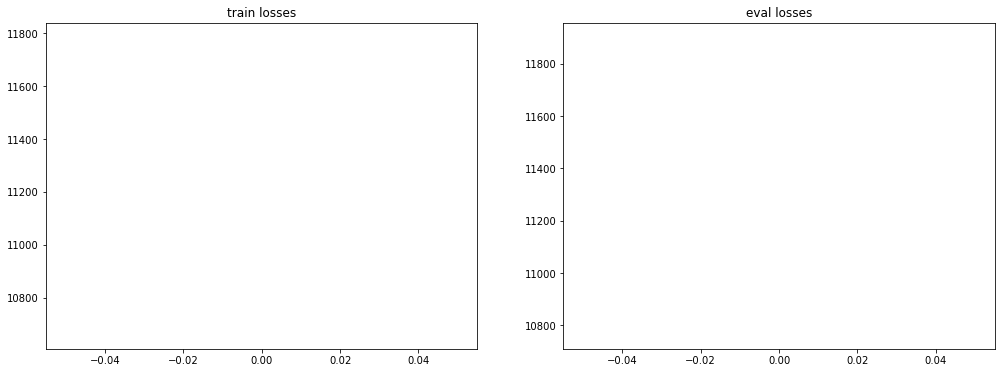

In [ ]:
# Training and evaluation losses by epoch

fig, ax = plt.subplots(1, 2, figsize=(17,6))

ax[0].plot(train_losses_epoch)
ax[0].set_title('train losses')
ax[1].plot(eval_losses_epoch)
ax[1].set_title('eval losses');

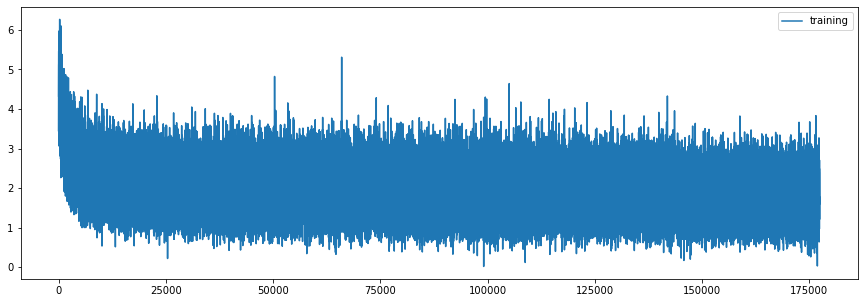

In [ ]:
# Training loss graphic

plt.figure(figsize=(15,5))
plt.plot(train_losses)
plt.legend(['training'])
plt.show()

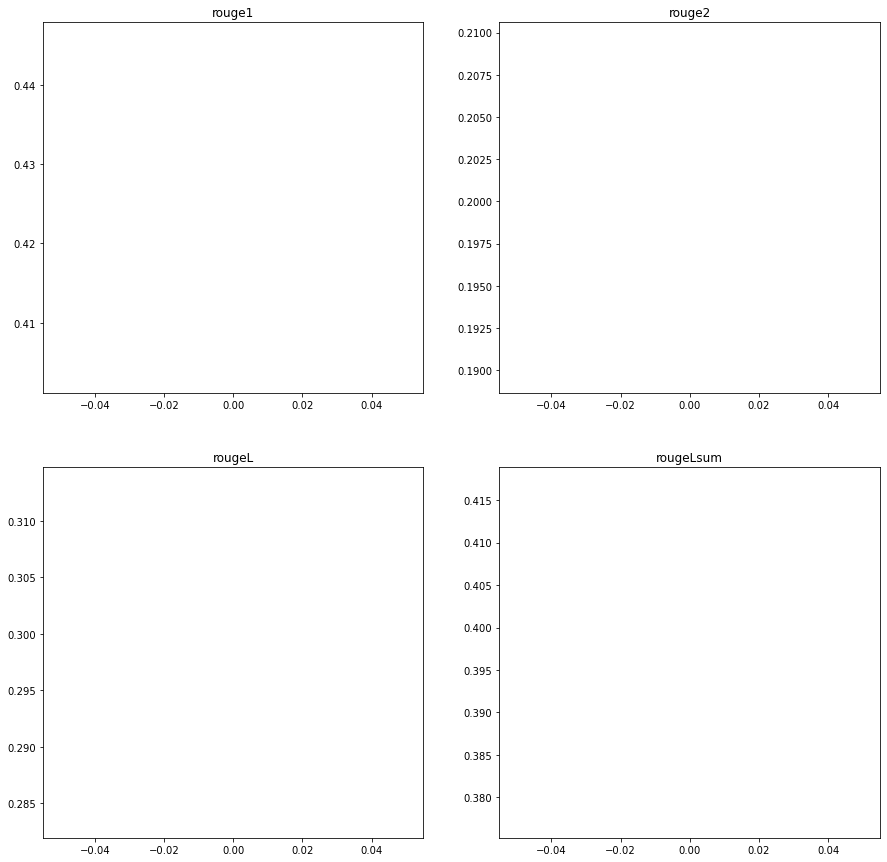

In [ ]:
# Metric graphics

rouge1 = []
rouge2 = []
rougeL = []
rougeLsum = []

for metric_i in metrics:
    metric = {key: value.mid.fmeasure for key, value in metric_i.items()}
    rouge1.append(metric['rouge1'])
    rouge2.append(metric['rouge2'])
    rougeL.append(metric['rougeL'])
    rougeLsum.append(metric['rougeLsum'])

fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0][0].plot(rouge1)
ax[0][0].set_title('rouge1')

ax[0][1].plot(rouge2)
ax[0][1].set_title('rouge2')

ax[1][0].plot(rougeL)
ax[1][0].set_title('rougeL')

ax[1][1].plot(rougeLsum)
ax[1][1].set_title('rougeLsum');

In [ ]:
some_summaries = []

In [ ]:
print('testing model')

gen_kwargs = {
    'max_length': 256,
    'num_beams': 3
}

for step, batch in enumerate(test_dataloader):
    batch = batch.to(device)
    with torch.no_grad():
        generated_tokens = model.generate(
            batch['input_ids'],
            attention_mask = batch['attention_mask'],
            **gen_kwargs                         
        )

        labels = batch['labels']

        labels = labels.cpu().numpy()
        generated_tokens = generated_tokens.cpu().numpy()

        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

        if step == 0 or step == 50 or step == 60 or step == 74:
            some_summaries.append((decoded_preds, decoded_labels))
            
        metric.add_batch(predictions=decoded_preds, references=decoded_labels)

        print(f'step {step + 1} / {len(test_dataloader)} completed')

test_result = metric.compute(use_stemmer=True)
result = {key: round(value.mid.fmeasure * 100, 4) for key, value in test_result.items()}

print(result)

testing model


AttributeError: 'dict' object has no attribute 'add_batch'

In [ ]:
result

{'rouge1': 42.4506, 'rouge2': 19.9627, 'rougeL': 29.8358, 'rougeLsum': 39.7059}

In [ ]:
for preds, labels in some_summaries:
    for pred, label in zip(preds, labels):
        print('pred')
        print(pred)
        print('label')
        print(label)
        print()
    

pred
James Best was best known for his role on "The Dukes of Hazzard"
He died in hospice in Hickory, North Carolina, of complications from pneumonia.
label
James Best, who played the sheriff on "The Dukes of Hazzard," died Monday at 88.
"Hazzard" ran from 1979 to 1985 and was among the most popular shows on TV.

pred
Dr. Anthony Moschetto, 54, pleads not guilty to all charges against him.
He is charged in what authorities say was a failed scheme to have another doctor hurt or killed.
Two other men are accused of being accomplices in the plot.
label
A lawyer for Dr. Anthony Moschetto says the charges against him are baseless.
Moschetto, 54, was arrested for selling drugs and weapons, prosecutors say.
Authorities allege Moschetto hired accomplices to burn down the practice of former associate.

pred
James Best was best known for his portrayal of bumbling sheriff Rosco P. Coltrane on "The Dukes of Hazzard"
Best died Monday after a brief illness.
label
James Best, who played the sheriff on

In [ ]:
some_summaries

[(['James Best was best known for his role on "The Dukes of Hazzard"\nHe died in hospice in Hickory, North Carolina, of complications from pneumonia.',
   'Dr. Anthony Moschetto, 54, pleads not guilty to all charges against him.\nHe is charged in what authorities say was a failed scheme to have another doctor hurt or killed.\nTwo other men are accused of being accomplices in the plot.'],
  ['James Best, who played the sheriff on "The Dukes of Hazzard," died Monday at 88.\n"Hazzard" ran from 1979 to 1985 and was among the most popular shows on TV.',
   'A lawyer for Dr. Anthony Moschetto says the charges against him are baseless.\nMoschetto, 54, was arrested for selling drugs and weapons, prosecutors say.\nAuthorities allege Moschetto hired accomplices to burn down the practice of former associate.'])]